In [1]:
import time
start_simulation = time.time()

import h5py

import numpy             as np
import matplotlib.pyplot as plt
import scipy.sparse      as spa
import scipy.special     as sp

import hylife.utilitis_FEEC.bsplines        as bsp
import hylife.utilitis_FEEC.spline_space    as spl
import hylife.utilitis_FEEC.derivatives     as der
import hylife.utilitis_FEEC.control_variate as cv

import hylife.utilitis_FEEC.basics.mass_matrices_3d  as mass
import hylife.utilitis_FEEC.basics.inner_products_3d as inner

import hylife.utilitis_FEEC.projectors.projectors_local     as proj
import hylife.utilitis_FEEC.projectors.projectors_local_mhd as mhd

import hylife.utilitis_PIC_April2020.STRUPHY_fields       as pic_fields
import hylife.utilitis_PIC_April2020.STRUPHY_pusher       as pic_pusher
import hylife.utilitis_PIC_April2020.STRUPHY_accumulation as pic_accumu
import hylife.utilitis_PIC_April2020.STRUPHY_sampling     as pic_sample
import hylife.utilitis_PIC_April2020.sobol_seq            as sobol

import hylife.interface as inter
import hylife.geometry.mappings_analytical as mapping    

In [2]:
# ======================== load parameters ============================
import simulations.simulation_05042020_1.parameters as pa    # name input folder here!
identifier = 'simulation_05042020_1'             # name input folder here!

params = pa.parameters()

Nel          = params.Nel            # mesh generation on logical domain
bc           = params.bc             # boundary conditions (True: periodic, False: else)
p            = params.p              # spline degrees

nq_el        = params.nq_el          # number of quadrature points per element for integrations over whole domain
nq_pr        = params.nq_pr          # number of quadrature points per integration interval of projectors


time_int     = params.time_int       # do time integration ?
dt           = params.dt             # time step
Tend         = params.Tend           # simulation time
max_time     = params.max_time       # maximum runtime of program in minutes
add_pressure = params.add_pressure   # add non-Hamiltonian terms to simulation?

# geometry
kind_map     = params.kind_map       # 1 : slab, 2 : hollow cylinder, 3 : colella
params_map   = params.params_map     # parameters for mapping  

# physical constants
gamma        = params.gamma          # adiabatic exponent

# particle parameters
add_PIC      = params.add_PIC        # add kinetic terms to simulation?
Np           = params.Np             # total number of particles
control      = params.control        # control variate on/off

v0x          = params.v0x            # shift of Maxwellian in vx - direction
v0y          = params.v0y            # shift of Maxwellian in vx - direction
v0z          = params.v0z            # shift of Maxwellian in vz - direction

vth          = params.vth            # thermal velocity of Maxwellian


loading      = params.loading        # particle loading



# restart function
restart        = params.restart  
create_restart = params.create_restart
num_restart    = params.num_restart

# ========================================================================

In [3]:
# ================== basics ==============================================

# element boundaries and spline knot vectors (N and D)
el_b         = [np.linspace(0., 1., Nel + 1) for Nel in Nel]                      
T            = [bsp.make_knots(el_b, p, bc) for el_b, p, bc in zip(el_b, p, bc)]
t            = [T[1:-1] for T in T] 

# 1d B-spline finite element spaces
spaces       = [spl.spline_space_1d(T, p, bc, nq_el) for T, p, bc, nq_el in zip(T, p, bc, nq_el)]

# 3d tensor-product B-spline spaces
tensor_space = spl.tensor_spline_space(spaces)


# number of basis functions in different spaces
NbaseN = tensor_space.NbaseN
NbaseD = tensor_space.NbaseD

Nbase_0form =  [NbaseN[0], NbaseN[1], NbaseN[2]]
Nbase_1form = [[NbaseD[0], NbaseN[1], NbaseN[2]], [NbaseN[0], NbaseD[1], NbaseN[2]], [NbaseN[0], NbaseN[1], NbaseD[2]]]
Nbase_2form = [[NbaseN[0], NbaseD[1], NbaseD[2]], [NbaseD[0], NbaseN[1], NbaseD[2]], [NbaseD[0], NbaseD[1], NbaseN[2]]]
Nbase_3form =  [NbaseD[0], NbaseD[1], NbaseD[2]]

Ntot_0form  =  NbaseN[0]*NbaseN[1]*NbaseN[2] 
Ntot_1form  = [NbaseD[0]*NbaseN[1]*NbaseN[2], NbaseN[0]*NbaseD[1]*NbaseN[2], NbaseN[0]*NbaseN[1]*NbaseD[2]]
Ntot_2form  = [NbaseN[0]*NbaseN[1]*NbaseD[2], NbaseD[0]*NbaseN[1]*NbaseD[2], NbaseD[0]*NbaseD[1]*NbaseN[2]]  
Ntot_3form  =  NbaseD[0]*NbaseD[1]*NbaseD[2]


if add_PIC == True:
    
    # delta-f corrections
    if control == True:
        cont = cv.terms_control_variate(tensor_space, kind_map, params_map)

    # particle accumulator
    acc = pic_accumu.accumulation(tensor_space)
    
    
# =======================================================================


# ==== coefficients for pp-forms in interval [0, delta] (N and D) for fast field evaluation
pp0 = []
pp1 = []

delta = tensor_space.delta

for i in range(3):
    
    if   p[i] == 1:
        pp0.append(np.asfortranarray([[1., -1/delta[i]], [0., 1/delta[i]]]))
        pp1.append(np.asfortranarray([[1/delta[i]]]))
    
    elif p[i] == 2:
        pp0.append(np.asfortranarray([[1/2, -1/delta[i], 1/(2*delta[i]**2)], [1/2, 1/delta[i], -1/delta[i]**2], [0., 0., 1/(2*delta[i]**2)]]))
        pp1.append(np.asfortranarray([[1., -1/delta[i]], [0., 1/delta[i]]])/delta[i])
    
    elif p[i] == 3:
        pp0.append(np.asfortranarray([[1/6, -1/(2*delta[i]), 1/(2*delta[i]**2), -1/(6*delta[i]**3)], [2/3, 0., -1/delta[i]**2, 1/(2*delta[i]**3)], [1/6, 1/(2*delta[i]), 1/(2*delta[i]**2), -1/(2*delta[i]**3)], [0., 0., 0., 1/(6*delta[i]**3)]]))
        pp1.append(np.asfortranarray([[1/2, -1/delta[i], 1/(2*delta[i]**2)], [1/2, 1/delta[i], -1/delta[i]**2], [0., 0., 1/(2*delta[i]**2)]])/delta[i])
    
    elif p[i] == 4:
        pp0.append(np.asfortranarray([[1/24, -1/(6*delta[i]), 1/(4*delta[i]**2), -1/(6*delta[i]**3), 1/(24*delta[i]**4)], [11/24, -1/(2*delta[i]), -1/(4*delta[i]**2), 1/(2*delta[i]**3), -1/(6*delta[i]**4)], [11/24, 1/(2*delta[i]), -1/(4*delta[i]**2), -1/(2*delta[i]**3), 1/(4*delta[i]**4)], [1/24, 1/(6*delta[i]), 1/(4*delta[i]**2), 1/(6*delta[i]**3), -1/(6*delta[i]**4)], [0., 0., 0., 0., 1/(24*delta[i]**4)]]))
        pp1.append(np.asfortranarray([[1/6, -1/(2*delta[i]), 1/(2*delta[i]**2), -1/(6*delta[i]**3)], [2/3, 0., -1/delta[i]**2, 1/(2*delta[i]**3)], [1/6, 1/(2*delta[i]), 1/(2*delta[i]**2), -1/(2*delta[i]**3)], [0., 0., 0., 1/(6*delta[i]**3)]])/delta[i])
    
    else:
        print('Spline degree > 4 not yet implemented!')
# ======================================================================

In [4]:
# ========= reserve memory for FEM cofficients and particles ===========
pr     = np.empty(Nbase_0form,    dtype=float, order='F')     # bulk pressure FEM coefficients

u1     = np.empty(Nbase_1form[0], dtype=float, order='F')     # bulk velocity FEM coefficients (1 - component)
u2     = np.empty(Nbase_1form[1], dtype=float, order='F')     # bulk velocity FEM coefficients (2 - component)
u3     = np.empty(Nbase_1form[2], dtype=float, order='F')     # bulk velocity FEM coefficients (3 - component)

u1_old = np.empty(Nbase_1form[0], dtype=float, order='F')     # bulk velocity FEM coefficients from previous time step (1 - component)
u2_old = np.empty(Nbase_1form[1], dtype=float, order='F')     # bulk velocity FEM coefficients from previous time step (2 - component)
u3_old = np.empty(Nbase_1form[2], dtype=float, order='F')     # bulk velocity FEM coefficients from previous time step (3 - component)

b1     = np.empty(Nbase_2form[0], dtype=float, order='F')     # magnetic field FEM coefficients (1 - component)
b2     = np.empty(Nbase_2form[1], dtype=float, order='F')     # magnetic field FEM coefficients (2 - component)
b3     = np.empty(Nbase_2form[2], dtype=float, order='F')     # magnetic field FEM coefficients (3 - component)

rho    = np.empty(Nbase_3form,    dtype=float, order='F')     # bulkmass density FEM coefficients


# particles
particles = np.empty((Np, 7), dtype=float, order='F')
w0        = np.empty(Np, dtype=float)
g0        = np.empty(Np, dtype=float)

# fields at particle positions (U and B)
B_part = np.empty((Np, 3), dtype=float, order='F')
U_part = np.empty((Np, 3), dtype=float, order='F')

# energies (bulk kinetic energy, magnetic energy, bulk internal energy, hot ion kinetic + internal energy (delta f))
energies = np.empty(4, dtype=float)
# =========================================================================

In [5]:
# ============= projection of initial conditions ==========================

# create object for projecting initial conditions
pro = proj.projectors_local_3d(tensor_space, nq_pr)

# projection of initial conditions
if params.ic_from_params == True:
    pr[:, :, :]                           = pro.pi_0(lambda xi1, xi2, xi3 : params.p_ini(xi1, xi2, xi3))
    u1[:, :, :], u2[:, :, :], u3[:, :, :] = pro.pi_1([lambda xi1, xi2, xi3 : params.u1_ini(xi1, xi2, xi3), lambda xi1, xi2, xi3 : params.u2_ini(xi1, xi2, xi3), lambda xi1, xi2, xi3 : params.u3_ini(xi1, xi2, xi3)]) 
    b1[:, :, :], b2[:, :, :], b3[:, :, :] = pro.pi_2([lambda xi1, xi2, xi3 : params.b1_ini(xi1, xi2, xi3), lambda xi1, xi2, xi3 : params.b2_ini(xi1, xi2, xi3), lambda xi1, xi2, xi3 : params.b3_ini(xi1, xi2, xi3)])
    rho[:, :, :]                          = pro.pi_3(lambda xi1, xi2, xi3 : params.rho_ini(xi1, xi2, xi3))
    
else:
    pr[:, :, :]                           = pro.pi_0( None,               1,        kind_map, params_map)
    u1[:, :, :], u2[:, :, :], u3[:, :, :] = pro.pi_1([None, None, None], [2, 3, 4], kind_map, params_map) 
    b1[:, :, :], b2[:, :, :], b3[:, :, :] = pro.pi_2([None, None, None], [5, 6, 7], kind_map, params_map)
    rho[:, :, :]                          = pro.pi_3( None,               8,        kind_map, params_map)

del pro

print('projection of initial conditions done!')
# ==========================================================================

projection of initial conditions done!


In [6]:
# plot initial conditions on physical domain
xiplot   = np.linspace(0., 1., 200), np.array([0.5]), np.array([0.5])
n_xiplot = [xiplot[0].size, xiplot[1].size, xiplot[2].size]

# evaluate mappings
xplot  = [np.empty((len(xiplot[0]), len(xiplot[1]), len(xiplot[2])), dtype=float, order='F') for i in range(3)]

DF     = [np.empty((len(xiplot[0]), len(xiplot[1]), len(xiplot[2])), dtype=float, order='F') for i in range(9)]
DF_inv = [np.empty((len(xiplot[0]), len(xiplot[1]), len(xiplot[2])), dtype=float, order='F') for i in range(9)]
det_DF =  np.empty((len(xiplot[0]), len(xiplot[1]), len(xiplot[2])), dtype=float, order='F')

components_x      = [1, 2, 3]
components_DF     = [11, 12, 13, 14, 15, 16, 17, 18, 19]
components_DF_inv = [21, 22, 23, 24, 25, 26, 27, 28, 29]

for i in range(3):
    
    mapping.kernel_eva(n_xiplot, xiplot[0], xiplot[1], xiplot[2], xplot[i], components_x[i], kind_map, params_map)
    
    for j in range(3):
        mapping.kernel_eva(n_xiplot, xiplot[0], xiplot[1], xiplot[2], DF[3*i + j], components_DF[3*i + j], kind_map, params_map)
        mapping.kernel_eva(n_xiplot, xiplot[0], xiplot[1], xiplot[2], DF_inv[3*i + j], components_DF_inv[3*i + j], kind_map, params_map)
        
mapping.kernel_eva(n_xiplot, xiplot[0], xiplot[1], xiplot[2], det_DF, 4, kind_map, params_map)

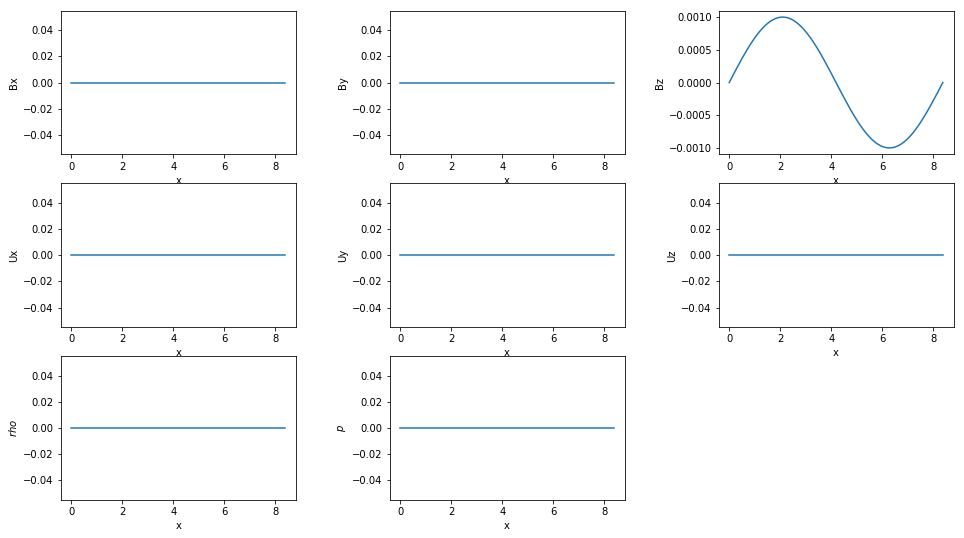

In [7]:
# evaluate forms on logical domain and plot on physical domain with push-forward

pini   = tensor_space.evaluate_0form_3d(pr, xiplot)

Uini1  = tensor_space.evaluate_1form_3d([u1, u2, u3], xiplot, 1)
Uini2  = tensor_space.evaluate_1form_3d([u1, u2, u3], xiplot, 2)
Uini3  = tensor_space.evaluate_1form_3d([u1, u2, u3], xiplot, 3)

Bini1  = tensor_space.evaluate_2form_3d([b1, b2, b3], xiplot, 1)
Bini2  = tensor_space.evaluate_2form_3d([b1, b2, b3], xiplot, 2)
Bini3  = tensor_space.evaluate_2form_3d([b1, b2, b3], xiplot, 3)

rhoini = tensor_space.evaluate_3form_3d(rho, xiplot)



fig = plt.figure()
fig.set_figwidth(16)
fig.set_figheight(9)

plt.subplot(3, 3, 1)
plt.plot(xplot[0][:, 0, 0], (DF[0][:, 0, 0]*Bini1[:, 0, 0] + DF[1][:, 0, 0]*Bini2[:, 0, 0] + DF[2][:, 0, 0]*Bini3[:, 0, 0])/det_DF[:, 0, 0])
plt.xlabel('x')
plt.ylabel('Bx')


plt.subplot(3, 3, 2)
plt.plot(xplot[0][:, 0, 0], (DF[3][:, 0, 0]*Bini1[:, 0, 0] + DF[4][:, 0, 0]*Bini2[:, 0, 0] + DF[5][:, 0, 0]*Bini3[:, 0, 0])/det_DF[:, 0, 0])
plt.xlabel('x')
plt.ylabel('By')

plt.subplot(3, 3, 3)
plt.plot(xplot[0][:, 0, 0], (DF[6][:, 0, 0]*Bini1[:, 0, 0] + DF[7][:, 0, 0]*Bini2[:, 0, 0] + DF[8][:, 0, 0]*Bini3[:, 0, 0])/det_DF[:, 0, 0])
plt.xlabel('x')
plt.ylabel('Bz')

plt.subplot(3, 3, 4)
plt.plot(xplot[0][:, 0, 0], DF_inv[0][:, 0, 0]*Uini1[:, 0, 0] + DF_inv[3][:, 0, 0]*Uini2[:, 0, 0] + DF_inv[6][:, 0, 0]*Uini3[:, 0, 0])
plt.xlabel('x')
plt.ylabel('Ux')

plt.subplot(3, 3, 5)
plt.plot(xplot[0][:, 0, 0], DF_inv[1][:, 0, 0]*Uini1[:, 0, 0] + DF_inv[4][:, 0, 0]*Uini2[:, 0, 0] + DF_inv[7][:, 0, 0]*Uini3[:, 0, 0])
plt.xlabel('x')
plt.ylabel('Uy')

plt.subplot(3, 3, 6)
plt.plot(xplot[0][:, 0, 0], DF_inv[2][:, 0, 0]*Uini1[:, 0, 0] + DF_inv[5][:, 0, 0]*Uini2[:, 0, 0] + DF_inv[8][:, 0, 0]*Uini3[:, 0, 0])
plt.xlabel('x')
plt.ylabel('Uz')


plt.subplot(3, 3, 7)
plt.plot(xplot[0][:, 0, 0], rhoini[:, 0, 0]/det_DF[:, 0, 0])
plt.xlabel('x')
plt.ylabel('$rho$')

plt.subplot(3, 3, 8)
plt.plot(xplot[0][:, 0, 0], pini[:, 0, 0])
plt.xlabel('x')
plt.ylabel('$p$')

plt.subplots_adjust(wspace=0.4)

In [8]:
# ==================== matrices ========================================

# create object for projecting MHD matrices
MHD = mhd.projectors_local_mhd(tensor_space, nq_pr)

# mass matrices in V0, V1 and V2
M0 = mass.mass_V0(tensor_space, kind_map, params_map)
M1 = mass.mass_V1(tensor_space, kind_map, params_map)
M2 = mass.mass_V2(tensor_space, kind_map, params_map)

# normalization vector in V0
norm = inner.inner_prod_V0(tensor_space, kind_map, params_map, lambda xi1, xi2, xi3 : np.ones(xi1.shape)).flatten()

# discrete grad, curl and div matrices
derivatives = der.discrete_derivatives(tensor_space)

GRAD = derivatives.grad_3d()
CURL = derivatives.curl_3d()
DIV  = derivatives.div_3d()

# projection matrices
Q   = MHD.projection_Q(kind_map, params_map)
W   = MHD.projection_W(kind_map, params_map)
TAU = MHD.projection_T(kind_map, params_map)
S   = MHD.projection_S(kind_map, params_map)
K   = MHD.projection_K(kind_map, params_map)


# compute matrix A
A = 1/2*(M1.dot(W) + W.T.dot(M1)).tocsc()

del W

# LU decompostion of Schur complement in step 2
STEP2_schur_LU = spa.linalg.splu((A + dt**2/4*TAU.T.dot(CURL.T.dot(M2.dot(CURL.dot(TAU))))).tocsc())

# other matrices needed in step 2
STEP2_1 = (A - dt**2/4*TAU.T.dot(CURL.T.dot(M2.dot(CURL.dot(TAU))))).tocsc()
STEP2_2 = dt*TAU.T.dot(CURL.T.dot(M2)).tocsc()

# matrices for non-Hamiltonian part
MAT = GRAD.T.dot(M1).dot(S) + (gamma - 1)*K.T.dot(GRAD.T).dot(M1)

del S, K

LHS_LU = spa.linalg.splu(spa.bmat([[spa.identity(Ntot_3form),  dt/2*DIV.dot(Q), None], [None, A,  dt/2*M1.dot(GRAD)], [None, -dt/2*MAT, M0]]).tocsc())
RHS    =                 spa.bmat([[spa.identity(Ntot_3form), -dt/2*DIV.dot(Q), None], [None, A, -dt/2*M1.dot(GRAD)], [None,  dt/2*MAT, M0]]).tocsc()

# delete everything which is not needed to save memory
del MHD, M0, GRAD, DIV, Q, MAT

print('assembly of constant matrices done!')
# =========================================================================

assembly of constant matrices done!


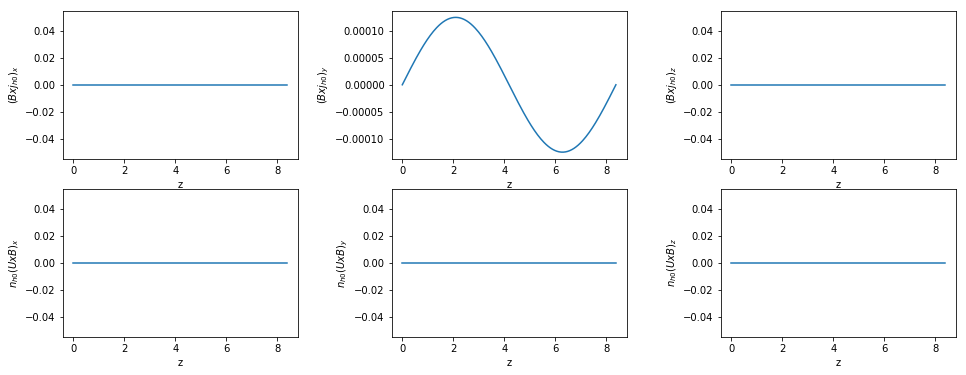

In [9]:
# check initial control variates
J14_control = cont.inner_prod_V1_jh_eq([b1, b2, b3])
J14_coeff1, J14_coeff2, J14_coeff3 = np.split(spa.linalg.spsolve(M1, np.concatenate((J14_control[0].flatten(), J14_control[1].flatten(), J14_control[2].flatten()))), [Ntot_1form[0], Ntot_1form[0] + Ntot_1form[1]])

J141 = tensor_space.evaluate_1form_3d([J14_coeff1, J14_coeff2, J14_coeff3], xiplot, 1)
J142 = tensor_space.evaluate_1form_3d([J14_coeff1, J14_coeff2, J14_coeff3], xiplot, 2)
J143 = tensor_space.evaluate_1form_3d([J14_coeff1, J14_coeff2, J14_coeff3], xiplot, 3)


J11_control = cont.mass_V1_nh_eq([b1, b2, b3])
J11_coeff1, J11_coeff2, J11_coeff3 = np.split(spa.linalg.spsolve(M1, -J11_control.dot(np.concatenate((u1.flatten(), u2.flatten(), u3.flatten())))), [Ntot_1form[0], Ntot_1form[0] + Ntot_1form[1]]) 

J111 = tensor_space.evaluate_1form_3d([J11_coeff1, J11_coeff2, J11_coeff3], xiplot, 1)
J112 = tensor_space.evaluate_1form_3d([J11_coeff1, J11_coeff2, J11_coeff3], xiplot, 2)
J113 = tensor_space.evaluate_1form_3d([J11_coeff1, J11_coeff2, J11_coeff3], xiplot, 3)


fig = plt.figure()
fig.set_figwidth(16)
fig.set_figheight(6)

plt.subplot(2, 3, 1)
plt.plot(xplot[0][:, 0, 0], DF_inv[0][:, 0, 0]*J141[:, 0, 0] + DF_inv[3][:, 0, 0]*J142[:, 0, 0] + DF_inv[6][:, 0, 0]*J143[:, 0, 0])
plt.xlabel('z')
plt.ylabel('$(B x j_{h0})_x$')

plt.subplot(2, 3, 2)
plt.plot(xplot[0][:, 0, 0], DF_inv[1][:, 0, 0]*J141[:, 0, 0] + DF_inv[4][:, 0, 0]*J142[:, 0, 0] + DF_inv[7][:, 0, 0]*J143[:, 0, 0])
plt.xlabel('z')
plt.ylabel('$(B x j_{h0})_y$')

plt.subplot(2, 3, 3)
plt.plot(xplot[0][:, 0, 0], DF_inv[2][:, 0, 0]*J141[:, 0, 0] + DF_inv[5][:, 0, 0]*J142[:, 0, 0] + DF_inv[8][:, 0, 0]*J143[:, 0, 0])
plt.xlabel('z')
plt.ylabel('$(B x j_{h0})_z$')

plt.subplot(2, 3, 4)
plt.plot(xplot[0][:, 0, 0], DF_inv[0][:, 0, 0]*J111[:, 0, 0] + DF_inv[3][:, 0, 0]*J112[:, 0, 0] + DF_inv[6][:, 0, 0]*J113[:, 0, 0])
plt.xlabel('z')
plt.ylabel('$n_{h0}(U x B)_x$')

plt.subplot(2, 3, 5)
plt.plot(xplot[0][:, 0, 0], DF_inv[1][:, 0, 0]*J111[:, 0, 0] + DF_inv[4][:, 0, 0]*J112[:, 0, 0] + DF_inv[7][:, 0, 0]*J113[:, 0, 0])
plt.xlabel('z')
plt.ylabel('$n_{h0}(U x B)_y$')

plt.subplot(2, 3, 6)
plt.plot(xplot[0][:, 0, 0], DF_inv[2][:, 0, 0]*J111[:, 0, 0] + DF_inv[5][:, 0, 0]*J112[:, 0, 0] + DF_inv[8][:, 0, 0]*J113[:, 0, 0])
plt.xlabel('z')
plt.ylabel('$n_{h0}(U x B)_z$')

plt.subplots_adjust(wspace=0.4)

In [10]:
# ================================================ create particles ====================================================
if   loading == 'pseudo-random':
    # pseudo-random numbers between (0, 1)
    particles[:, :6] = np.random.rand(Np, 6)
    
elif loading == 'sobol_standard':
    # plain sobol numbers between (0, 1) (skip first 1000 numbers)
    particles[:, :6] = sobol.i4_sobol_generate(6, Np, 1000) 
    
elif loading == 'sobol_antithetic':
    # symmetric sobol numbers between (0, 1) (skip first 1000 numbers) in all 6 dimensions
    pic_sample.set_particles_symmetric(sobol.i4_sobol_generate(6, int(Np/64), 1000), particles)  
    
elif loading == 'pr_space_uni_velocity':
    # pseudo-random numbers in space and uniform in velocity space
    particles[:, :3] = np.random.rand(Np, 3)
    
    dv = 1/Np
    particles[:,  3] = np.linspace(dv, 1 - dv, Np)
    particles[:,  4] = np.linspace(dv, 1 - dv, Np)
    particles[:,  5] = np.linspace(dv, 1 - dv, Np)
    
elif loading == 'external':
    # load numbers between (0, 1) from an external file
    particles[:, :6] = np.load('test_particles.npy')
    
else:
    print('particle loading not specified')

# inversion of cumulative distribution function
particles[:, 3]  = sp.erfinv(2*particles[:, 3] - 1)*vth + v0x
particles[:, 4]  = sp.erfinv(2*particles[:, 4] - 1)*vth + v0y
particles[:, 5]  = sp.erfinv(2*particles[:, 5] - 1)*vth + v0z

# compute initial weights
pic_sample.compute_weights_ini(particles, w0, g0, kind_map, params_map)

if control == True:
    pic_sample.update_weights(particles, w0, g0, kind_map, params_map)
else:
    particles[:, 6] = w0

print('particle initialization done!')
# =====================================================================================================================

particle initialization done!


In [11]:
# ================ compute initial fields at particle positions and initial energies ==================================
if add_PIC == True:
    timea = time.time()
    pic_fields.evaluate_2form(particles[:, 0:3], T[0], T[1], T[2], t[0], t[1], t[2], p, Nel, np.asfortranarray(Nbase_2form), Np, b1, b2, b3, pp0[0], pp0[1], pp0[2], pp1[0], pp1[1], pp1[2], B_part, kind_map, params_map)
    pic_fields.evaluate_1form(particles[:, 0:3], T[0], T[1], T[2], t[0], t[1], t[2], p, Nel, np.asfortranarray(Nbase_1form), Np, u1, u2, u3, pp0[0], pp0[1], pp0[2], pp1[0], pp1[1], pp1[2], U_part, kind_map, params_map)
    timeb = time.time()
    print('initial field computation at particles done. Time : ', timeb-timea)


# initial energies
energies[0] = 1/2*np.concatenate((u1.flatten(), u2.flatten(), u3.flatten())).dot(A.dot(np.concatenate((u1.flatten(), u2.flatten(), u3.flatten()))))
energies[1] = 1/2*np.concatenate((b1.flatten(), b2.flatten(), b3.flatten())).dot(M2.dot(np.concatenate((b1.flatten(), b2.flatten(), b3.flatten()))))
energies[2] = 1/(gamma - 1)*pr.flatten().dot(norm)
energies[3] = 1/2*particles[:, 6].dot(particles[:, 3]**2 + particles[:, 4]**2 + particles[:, 5]**2)/Np + (control - 1)*inter.eh_eq(kind_map, params_map)
# =====================================================================================================================

initial field computation at particles done. Time :  0.38802671432495117


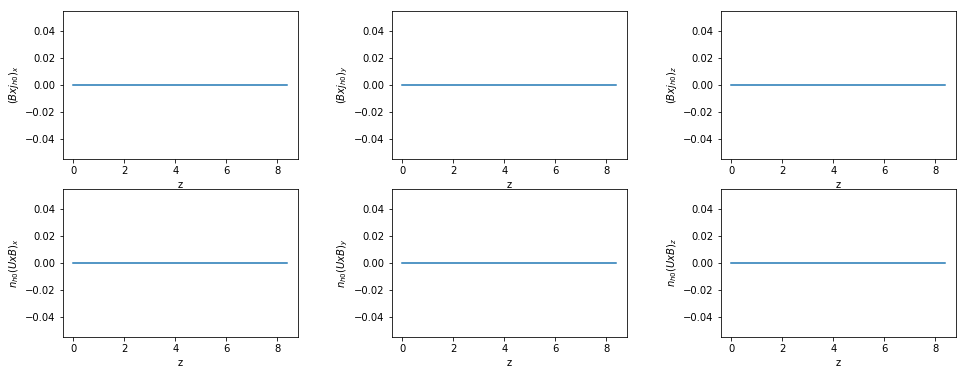

In [12]:
# check initial accumulation terms
J14 = acc.accumulation_step3(particles, B_part, kind_map, params_map)[1]
J14_coeff1, J14_coeff2, J14_coeff3 = np.split(spa.linalg.spsolve(M1,  J14/Np), [Ntot_1form[0], Ntot_1form[0] + Ntot_1form[1]])

J141 = tensor_space.evaluate_1form_3d([J14_coeff1, J14_coeff2, J14_coeff3], xiplot, 1)
J142 = tensor_space.evaluate_1form_3d([J14_coeff1, J14_coeff2, J14_coeff3], xiplot, 2)
J143 = tensor_space.evaluate_1form_3d([J14_coeff1, J14_coeff2, J14_coeff3], xiplot, 3)


J11 = acc.accumulation_step1(particles, B_part, kind_map, params_map)
J11_coeff1, J11_coeff2, J11_coeff3 = np.split(spa.linalg.spsolve(M1, -J11.dot(np.concatenate((u1.flatten(), u2.flatten(), u3.flatten())))), [Ntot_1form[0], Ntot_1form[0] + Ntot_1form[1]]) 

J111 = tensor_space.evaluate_1form_3d([J11_coeff1, J11_coeff2, J11_coeff3], xiplot, 1)
J112 = tensor_space.evaluate_1form_3d([J11_coeff1, J11_coeff2, J11_coeff3], xiplot, 2)
J113 = tensor_space.evaluate_1form_3d([J11_coeff1, J11_coeff2, J11_coeff3], xiplot, 3)

fig = plt.figure()
fig.set_figwidth(16)
fig.set_figheight(6)

plt.subplot(2, 3, 1)
plt.plot(xplot[0][:, 0, 0], DF_inv[0][:, 0, 0]*J141[:, 0, 0] + DF_inv[3][:, 0, 0]*J142[:, 0, 0] + DF_inv[6][:, 0, 0]*J143[:, 0, 0])
plt.xlabel('z')
plt.ylabel('$(B x j_{h0})_x$')

plt.subplot(2, 3, 2)
plt.plot(xplot[0][:, 0, 0], DF_inv[1][:, 0, 0]*J141[:, 0, 0] + DF_inv[4][:, 0, 0]*J142[:, 0, 0] + DF_inv[7][:, 0, 0]*J143[:, 0, 0])
plt.xlabel('z')
plt.ylabel('$(B x j_{h0})_y$')

plt.subplot(2, 3, 3)
plt.plot(xplot[0][:, 0, 0], DF_inv[2][:, 0, 0]*J141[:, 0, 0] + DF_inv[5][:, 0, 0]*J142[:, 0, 0] + DF_inv[8][:, 0, 0]*J143[:, 0, 0])
plt.xlabel('z')
plt.ylabel('$(B x j_{h0})_z$')

plt.subplot(2, 3, 4)
plt.plot(xplot[0][:, 0, 0], DF_inv[0][:, 0, 0]*J111[:, 0, 0] + DF_inv[3][:, 0, 0]*J112[:, 0, 0] + DF_inv[6][:, 0, 0]*J113[:, 0, 0])
plt.xlabel('z')
plt.ylabel('$n_{h0}(U x B)_x$')

plt.subplot(2, 3, 5)
plt.plot(xplot[0][:, 0, 0], DF_inv[1][:, 0, 0]*J111[:, 0, 0] + DF_inv[4][:, 0, 0]*J112[:, 0, 0] + DF_inv[7][:, 0, 0]*J113[:, 0, 0])
plt.xlabel('z')
plt.ylabel('$n_{h0}(U x B)_y$')

plt.subplot(2, 3, 6)
plt.plot(xplot[0][:, 0, 0], DF_inv[2][:, 0, 0]*J111[:, 0, 0] + DF_inv[5][:, 0, 0]*J112[:, 0, 0] + DF_inv[8][:, 0, 0]*J113[:, 0, 0])
plt.xlabel('z')
plt.ylabel('$n_{h0}(U x B)_z$')

plt.subplots_adjust(wspace=0.4)

In [13]:
# ==================== time integrator ==========================================    
def update():
    
    # step 1 (1 : update u)
    if add_PIC == True:
        mat = -acc.accumulation_step1(particles, B_part, kind_map, params_map)/Np

        if control == True:
            mat -= cont.mass_V1_nh_eq([b1, b2, b3])

        temp1, temp2, temp3 = np.split(spa.linalg.spsolve(A - dt/2*mat, (A + dt/2*mat).dot(np.concatenate((u1.flatten(), u2.flatten(), u3.flatten())))), [Ntot_1form[0], Ntot_1form[0] + Ntot_1form[1]])

        u1[:, :, :] = temp1.reshape(Nbase_1form[0])
        u2[:, :, :] = temp2.reshape(Nbase_1form[1])
        u3[:, :, :] = temp3.reshape(Nbase_1form[2])
                                   
    
    # step 2 (1 : update u, 2 : update b, 3 : evaluate B-field at particle positions)
    u1_old[:, :, :] = u1[:, :, :]
    u2_old[:, :, :] = u2[:, :, :]
    u3_old[:, :, :] = u3[:, :, :]
    
    temp1, temp2, temp3 = np.split(STEP2_schur_LU.solve(STEP2_1.dot(np.concatenate((u1.flatten(), u2.flatten(), u3.flatten()))) + STEP2_2.dot(np.concatenate((b1.flatten(), b2.flatten(), b3.flatten())))), [Ntot_1form[0], Ntot_1form[0] + Ntot_1form[1]])
    
    u1[:, :, :] = temp1.reshape(Nbase_1form[0])
    u2[:, :, :] = temp2.reshape(Nbase_1form[1])
    u3[:, :, :] = temp3.reshape(Nbase_1form[2])
    
    temp1, temp2, temp3 = np.split(np.concatenate((b1.flatten(), b2.flatten(), b3.flatten())) - dt/2*CURL.dot(TAU.dot(np.concatenate((u1.flatten(), u2.flatten(), u3.flatten())) + np.concatenate((u1_old.flatten(), u2_old.flatten(), u3_old.flatten())))), [Ntot_2form[0], Ntot_2form[0] + Ntot_2form[1]]) 
    
    b1[:, :, :] = temp1.reshape(Nbase_2form[0])
    b2[:, :, :] = temp2.reshape(Nbase_2form[1])
    b3[:, :, :] = temp3.reshape(Nbase_2form[2])
    
    
    if add_PIC == True:
        pic_fields.evaluate_2form(particles[:, 0:3], T[0], T[1], T[2], t[0], t[1], t[2], p, Nel, np.asfortranarray(Nbase_2form), Np, b1, b2, b3, pp0[0], pp0[1], pp0[2], pp1[0], pp1[1], pp1[2], B_part, kind_map, params_map)
    
        # step 3 (1 : update u, 2 : evaluate U-field at particle positions, 3 : update particles velocities (V))
        u1_old[:, :, :] = u1[:, :, :]
        u2_old[:, :, :] = u2[:, :, :]
        u3_old[:, :, :] = u3[:, :, :]

        mat, vec = acc.accumulation_step3(particles, B_part, kind_map, params_map)

        if control == True:
            vec_cv = cont.inner_prod_V1_jh_eq([b1, b2, b3])

            temp1, temp2, temp3 = np.split(spa.linalg.spsolve(A + dt**2/4*mat/Np, (A - dt**2/4*mat/Np).dot(np.concatenate((u1_old.flatten(), u2_old.flatten(), u3_old.flatten()))) + dt*vec/Np + dt*np.concatenate((vec_cv[0].flatten(), vec_cv[1].flatten(), vec_cv[2].flatten()))), [Ntot_1form[0], Ntot_1form[0] + Ntot_1form[1]]) 

            u1[:, :, :] = temp1.reshape(Nbase_1form[0])
            u2[:, :, :] = temp2.reshape(Nbase_1form[1])
            u3[:, :, :] = temp3.reshape(Nbase_1form[2])

        else:
            temp1, temp2, temp3 = np.split(spa.linalg.spsolve(A + dt**2/4*mat/Np, (A - dt**2/4*mat/Np).dot(np.concatenate((u1_old.flatten(), u2_old.flatten(), u3_old.flatten()))) + dt*vec/Np), [Ntot_1form[0], Ntot_1form[0] + Ntot_1form[1]]) 

            u1[:, :, :] = temp1.reshape(Nbase_1form[0])
            u2[:, :, :] = temp2.reshape(Nbase_1form[1])
            u3[:, :, :] = temp3.reshape(Nbase_1form[2])

        pic_fields.evaluate_1form(particles[:, 0:3], T[0], T[1], T[2], t[0], t[1], t[2], p, Nel, np.asfortranarray(Nbase_1form), Np, (u1 + u1_old)/2, (u2 + u2_old)/2, (u3 + u3_old)/2, pp0[0], pp0[1], pp0[2], pp1[0], pp1[1], pp1[2], U_part, kind_map, params_map)

        pic_pusher.pusher_step3(particles, dt, B_part, U_part, kind_map, params_map)

        # step 4 (1 : update particles positions (Xi))
        pic_pusher.pusher_step4(particles, dt, kind_map, params_map)

        # step 5 (1 : update particle veclocities (V), 2 : update particle weights (W))
        pic_fields.evaluate_2form(particles[:, 0:3], T[0], T[1], T[2], t[0], t[1], t[2], p, Nel, np.asfortranarray(Nbase_2form), Np, b1, b2, b3, pp0[0], pp0[1], pp0[2], pp1[0], pp1[1], pp1[2], B_part, kind_map, params_map)
        pic_pusher.pusher_step5(particles, dt, B_part, kind_map, params_map)

        if control == True:
            pic_sample.update_weights(particles, w0, g0, kind_map, params_map)
    
    # step 6 (1 : update rho, u and p from non-Hamiltonian terms)
    if add_pressure == True:
        temp1, temp21, temp22, temp23, temp3 = np.split(LHS_LU.solve(RHS.dot(np.concatenate((rho.flatten(), np.concatenate((u1.flatten(), u2.flatten(), u3.flatten())), pr.flatten())))), [Ntot_3form, Ntot_3form + Ntot_1form[0], Ntot_3form + Ntot_1form[0] + Ntot_1form[1], Ntot_3form + Ntot_1form[0] + Ntot_1form[1] + Ntot_1form[2]])
        
        rho[:, :, :] = temp1.reshape(Nbase_3form)
        u1[:, :, :]  = temp21.reshape(Nbase_1form[0])
        u2[:, :, :]  = temp22.reshape(Nbase_1form[1])
        u3[:, :, :]  = temp23.reshape(Nbase_1form[2])
        pr[:, :, :]  = temp3.reshape(Nbase_0form)
                                       
        
    # diagnostics (compute energies)
    energies[0] = 1/2*np.concatenate((u1.flatten(), u2.flatten(), u3.flatten())).dot(A.dot(np.concatenate((u1.flatten(), u2.flatten(), u3.flatten()))))
    energies[1] = 1/2*np.concatenate((b1.flatten(), b2.flatten(), b3.flatten())).dot(M2.dot(np.concatenate((b1.flatten(), b2.flatten(), b3.flatten()))))
    energies[2] = 1/(gamma - 1)*pr.flatten().dot(norm)
    energies[3] = 1/2*particles[:, 6].dot(particles[:, 3]**2 + particles[:, 4]**2 + particles[:, 5]**2)/Np + (control - 1)*inter.eh_eq(kind_map, params_map)
# ============================================================================

In [14]:
# ========================== time integration ================================
if time_int == True:
    
    # a new simulation
    if restart == False:
        
        # create hdf5 file and datasets for simulation output
        file = h5py.File('simulations/' + identifier + '/testhdf5_' + identifier, 'a')
        
        file.create_dataset('pressure', (1, Nbase_0form[0], Nbase_0form[1], Nbase_0form[2]), maxshape=(None, Nbase_0form[0], Nbase_0form[1], Nbase_0form[2]), dtype=float, chunks=True)
        
        file.create_dataset('velocity_field/1_component', (1, Nbase_1form[0][0], Nbase_1form[0][1], Nbase_1form[0][2]), maxshape=(None, Nbase_1form[0][0], Nbase_1form[0][1], Nbase_1form[0][2]), dtype=float, chunks=True)
        file.create_dataset('velocity_field/2_component', (1, Nbase_1form[1][0], Nbase_1form[1][1], Nbase_1form[1][2]), maxshape=(None, Nbase_1form[1][0], Nbase_1form[1][1], Nbase_1form[1][2]), dtype=float, chunks=True)
        file.create_dataset('velocity_field/3_component', (1, Nbase_1form[2][0], Nbase_1form[2][1], Nbase_1form[2][2]), maxshape=(None, Nbase_1form[2][0], Nbase_1form[2][1], Nbase_1form[2][2]), dtype=float, chunks=True)
        
        file.create_dataset('magnetic_field/1_component', (1, Nbase_2form[0][0], Nbase_2form[0][1], Nbase_2form[0][2]), maxshape=(None, Nbase_2form[0][0], Nbase_2form[0][1], Nbase_2form[0][2]), dtype=float, chunks=True)
        file.create_dataset('magnetic_field/2_component', (1, Nbase_2form[1][0], Nbase_2form[1][1], Nbase_2form[1][2]), maxshape=(None, Nbase_2form[1][0], Nbase_2form[1][1], Nbase_2form[1][2]), dtype=float, chunks=True)
        file.create_dataset('magnetic_field/3_component', (1, Nbase_2form[2][0], Nbase_2form[2][1], Nbase_2form[2][2]), maxshape=(None, Nbase_2form[2][0], Nbase_2form[2][1], Nbase_2form[2][2]), dtype=float, chunks=True)
        
        file.create_dataset('density', (1, Nbase_3form[0], Nbase_3form[1], Nbase_3form[2]), maxshape=(None, Nbase_3form[0], Nbase_3form[1], Nbase_3form[2]), dtype=float, chunks=True)
        
        file.create_dataset('energies', (1, 4), maxshape=(None, 4), dtype=float, chunks=True)
        
        file.create_dataset('time', (1, ), maxshape=(None, ), dtype=float, chunks=True)
        
        
        # datasets for restart function
        file.create_dataset('restart/particles', (1, Np, 7), maxshape=(None, Np, 7), dtype=float, chunks=True)
        
        file.create_dataset('restart/control_w0', (Np,), dtype=float)
        file.create_dataset('restart/control_g0', (Np,), dtype=float)
        
        file.create_dataset('restart/pressure', (1, Nbase_0form[0], Nbase_0form[1], Nbase_0form[2]), maxshape=(None, Nbase_0form[0], Nbase_0form[1], Nbase_0form[2]), dtype=float, chunks=True)
        
        file.create_dataset('restart/velocity_field/1_component', (1, Nbase_1form[0][0], Nbase_1form[0][1], Nbase_1form[0][2]), maxshape=(None, Nbase_1form[0][0], Nbase_1form[0][1], Nbase_1form[0][2]), dtype=float, chunks=True)
        file.create_dataset('restart/velocity_field/2_component', (1, Nbase_1form[1][0], Nbase_1form[1][1], Nbase_1form[1][2]), maxshape=(None, Nbase_1form[1][0], Nbase_1form[1][1], Nbase_1form[1][2]), dtype=float, chunks=True)
        file.create_dataset('restart/velocity_field/3_component', (1, Nbase_1form[2][0], Nbase_1form[2][1], Nbase_1form[2][2]), maxshape=(None, Nbase_1form[2][0], Nbase_1form[2][1], Nbase_1form[2][2]), dtype=float, chunks=True)
        
        file.create_dataset('restart/magnetic_field/1_component', (1, Nbase_2form[0][0], Nbase_2form[0][1], Nbase_2form[0][2]), maxshape=(None, Nbase_2form[0][0], Nbase_2form[0][1], Nbase_2form[0][2]), dtype=float, chunks=True)
        file.create_dataset('restart/magnetic_field/2_component', (1, Nbase_2form[1][0], Nbase_2form[1][1], Nbase_2form[1][2]), maxshape=(None, Nbase_2form[1][0], Nbase_2form[1][1], Nbase_2form[1][2]), dtype=float, chunks=True)
        file.create_dataset('restart/magnetic_field/3_component', (1, Nbase_2form[2][0], Nbase_2form[2][1], Nbase_2form[2][2]), maxshape=(None, Nbase_2form[2][0], Nbase_2form[2][1], Nbase_2form[2][2]), dtype=float, chunks=True)
        
        file.create_dataset('restart/density', (1, Nbase_3form[0], Nbase_3form[1], Nbase_3form[2]), maxshape=(None, Nbase_3form[0], Nbase_3form[1], Nbase_3form[2]), dtype=float, chunks=True)
        
        file.create_dataset('restart/time_step', (1, ), maxshape=(None, ), dtype=int, chunks=True)
        
        
        # == save initial data ============
        
        file['magnetic_field/1_component'][0] = b1
        file['magnetic_field/2_component'][0] = b2
        file['magnetic_field/3_component'][0] = b3
        
        file['energies'][0] = energies
        file['time'][0] = 0.
        
        file['restart/control_w0'][:] = w0
        file['restart/control_g0'][:] = g0
          
        # =================================

        print('initial energies : ', energies)
        time_step = 0
        
    # restarting another simulation
    else:
        
        # open existing hdf5 file
        file = h5py.File('simulations/' + identifier + '/testhdf5_' + identifier, 'a')
        
        # load restart data from last time step
        time_step       = file['restart/time_step'][num_restart]
        
        particles[:, :] = file['restart/particles'][num_restart]
        w0[:]           = file['restart/control_w0'][num_restart]
        g0[:]           = file['restart/control_g0'][num_restart]
        
        pr[:, :, :]     = file['restart/pressure'][num_restart]
        
        u1[:, :, :]     = file['restart/velocity_field/1_component'][num_restart]
        u2[:, :, :]     = file['restart/velocity_field/2_component'][num_restart]
        u3[:, :, :]     = file['restart/velocity_field/3_component'][num_restart]
        
        b1[:, :, :]     = file['restart/magnetic_field/1_component'][num_restart]
        b2[:, :, :]     = file['restart/magnetic_field/2_component'][num_restart]
        b3[:, :, :]     = file['restart/magnetic_field/3_component'][num_restart]
        
        rho[:, :, :]    = file['restart/density'][num_restart]
        
        # perform initialization for next time step
        pic_fields.evaluate_2form(particles[:, 0:3], T[0], T[1], T[2], t[0], t[1], t[2], p, Nel, np.asfortranarray(Nbase_2form), Np, b1, b2, b3, pp0[0], pp0[1], pp0[2], pp1[0], pp1[1], pp1[2], B_part, kind_map, params_map)
        pic_fields.evaluate_1form(particles[:, 0:3], T[0], T[1], T[2], t[0], t[1], t[2], p, Nel, np.asfortranarray(Nbase_1form), Np, u1, u2, u3, pp0[0], pp0[1], pp0[2], pp1[0], pp1[1], pp1[2], U_part, kind_map, params_map)
        
        pic_sample.update_weights(particles, w0, g0, kind_map, params_map)

        
    
    
    
    # ===========================================
    #              time loop 
    # ===========================================
    print('start time integration! (total number of time steps : ' + str(int(Tend/dt)) + ')')
    # ===========================================
    
    
    while True:

        if (time_step*dt >= Tend) or ((time.time() - start_simulation)/60 > max_time):
            
            if create_restart:
                
                if file['restart/time_step'].shape[0] > 1:
                    
                    file['restart/time_step'].resize(file['restart/time_step'].shape[0] + 1, axis = 0)
                    file['restart/particles'].resize(file['restart/particles'].shape[0] + 1, axis = 0)
                    file['restart/pressure'].resize(file['restart/pressure'].shape[0] + 1, axis = 0)
                    file['restart/velocity_field/1_component'].resize(file['restart/velocity_field/1_component'].shape[0] + 1, axis = 0)
                    file['restart/velocity_field/2_component'].resize(file['restart/velocity_field/2_component'].shape[0] + 1, axis = 0)
                    file['restart/velocity_field/3_component'].resize(file['restart/velocity_field/3_component'].shape[0] + 1, axis = 0)
                    file['restart/magnetic_field/1_component'].resize(file['restart/magnetic_field/1_component'].shape[0] + 1, axis = 0)
                    file['restart/magnetic_field/2_component'].resize(file['restart/magnetic_field/2_component'].shape[0] + 1, axis = 0)
                    file['restart/magnetic_field/3_component'].resize(file['restart/magnetic_field/3_component'].shape[0] + 1, axis = 0)
                    file['restart/density'].resize(file['restart/density'].shape[0] + 1, axis = 0)
                
                file['restart/time_step'][-1] = time_step
                file['restart/particles'][-1] = particles
                file['restart/pressure'][-1] = pr
                file['restart/velocity_field/1_component'][-1] = u1
                file['restart/velocity_field/2_component'][-1] = u2
                file['restart/velocity_field/3_component'][-1] = u3
                file['restart/magnetic_field/1_component'][-1] = b1
                file['restart/magnetic_field/2_component'][-1] = b2
                file['restart/magnetic_field/3_component'][-1] = b3
                file['restart/density'][-1] = rho
            
            break

        if time_step%10 == 0:
            print('time steps finished : ' + str(time_step))
            print('energies : ', energies)

        timea = time.time()
        update()
        timeb = time.time()

        if time_step == 0:
            print('time for one time step : ', timeb - timea)

        # == data to save ==========
        file['time'].resize(file['time'].shape[0] + 1, axis = 0)
        
        file['time'][-1] = (time_step + 1)*dt
        
        file['magnetic_field/1_component'].resize(file['magnetic_field/1_component'].shape[0] + 1, axis = 0)
        file['magnetic_field/2_component'].resize(file['magnetic_field/2_component'].shape[0] + 1, axis = 0)
        file['magnetic_field/3_component'].resize(file['magnetic_field/3_component'].shape[0] + 1, axis = 0)
        
        file['magnetic_field/1_component'][-1] = b1
        file['magnetic_field/2_component'][-1] = b2
        file['magnetic_field/3_component'][-1] = b3
        
        file['energies'].resize(file['energies'].shape[0] + 1, axis = 0)
        file['energies'][-1] = energies
        
        # ==========================

        time_step += 1

    file.close()
# ============================================================================

initial energies :  [0.00000000e+00 2.09356489e-06 0.00000000e+00 0.00000000e+00]
start time integration! (total number of time steps : 20)
time steps finished : 0
energies :  [0.00000000e+00 2.09356489e-06 0.00000000e+00 0.00000000e+00]
time for one time step :  1.3606324195861816
time steps finished : 10
energies :  [ 4.12726280e-07  1.69697907e-06  0.00000000e+00 -1.00221444e-08]
